<a href="https://colab.research.google.com/github/joanall/Hands-On-Epigenome-Wide-Analysis-EWAS-/blob/main/ewas_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Hands-on Data EWAS Analysis Tutorial**  

Joana Llauradó, Predoctoral Researcher at the Barcelona Institute for Global Health (ISGlobal).

Mariona Bustamante, Senior Research Scientist at the Barcelona Institute for Global Health (ISGlobal).


**Objective:** his hands-on exercise focuses on the analysis phase of an Epigenome-Wide Association Study (EWAS). Using preprocessed DNA methylation data, participants will learn how to identify associations between an environmental exposure—such as smoking—and methylation levels across the genome.


**Description:** During this practical, we will perform EWAS analysis and basic downstream interpretation to gain biological insight from the results. Participants will learn how to run association models, correct for multiple testing, visualize significant findings (e.g., using Manhattan and QQ plots), and interpret the top CpG sites and enriched pathways related to the exposure of interest.

**Based on/adapted from** Previous course Summer School in Global Health 2023-EWAS https://github.com/isglobal-brge/course_methylation?tab=readme-ov-file

**Considerations**
* The data quality control (QC) step will not be assessed in this session. However, participants can explore QC independently using the example code provided in here: https://github.com/isglobal-brge/course_methylation?tab=readme-ov-file

* Public data from [link] It must be noted that this data is public and has been revied/selcetd to be able tor un this nalaysis in a short period of time. Ewas data usually is upt to XXXX GB and a compute with enough memory or clsuter is nneded to run this nalaysis. Also the time needed is higher than the one for this Hands-on.

**Reminder: Introduction to NoteBook**
Within this notebook (NoteBook), you will be guided step by step from loading a dataset to performing analysis of its content.

The Jupyter (Python) notebook is an approach that combines text blocks (like this one) together with code blocks or cells.

**Conisderations**
* The **order of instructions** is fundamental, so each cell in this notebook must be executed sequentially. If any are omitted, the program may throw an error, so you should start from the beginning if in doubt.

* At the start you select **"Open in draft mode"** (draft mode), at the top left. Otherwise, it will not allow you to execute any code block, for security reasons. When the first of the blocks is executed, the following message will appear: "Warning: This notebook was not created by Google.". Do not worry, you should trust the content of the notebook (NoteBook) and click "Run anyway".

**Let’s go!**

Click the "play" button on the left side of each code cell. Lines of code that begin with a hashtag (#) are comments and do not affect the execution of the program.

You can also click on each cell and press "ctrl+enter" (cmd+enter on Mac).Each time you run a block, you will see the output just below it.

# **INDEX**
1. [Installation of the R environment and libraries for EWAS analyses](#install-libraries)
2. [Load the Data](#load-data)
3. [Quality Control](#qc)
4. [Run EWAS](#ewas)   
5. [Downstream Analysis](#da)   


# **1. Installation of the R Environment and Libraries for EWAS Analysis** <a name="install-libraries"></a>

Below, we install/load the libraries necessary for this session. In the context of exposome analysis, R libraries offer us a much more convenient way to process, manipulate, and analyze the data. Some of these libraries: `tidyverse`, `name_library`  
  
The installation of R in our Google Colab environment will be carried out in the following code block. It should be remembered that all library installations we perform in the Google Colab environment will only remain active for a few hours, after which the installed libraries are removed. Therefore, it will be necessary for you to re-run the library installation code in this section whenever you need to run the notebook again after this time.

Before starting, make sure the required R packages are available. We recommend installing the libraries **30 minutes** before the start of the session❗❗❗

* **On your local machine (RStudio, etc.)**: you usually install once, then just load them in each new R session.

* **In Google Colab:** the runtime is temporary, when it resets or disconnects, previously installed packages can disappear. Therefore we need to install each time at the start of every session.

In [3]:
# Estimated execution time: 73 minuts = 1.20 aprox (all the packages), now it takes 10-20'
t0 <- Sys.time()

####################################### INSTALLING ####################################################

# Make sure Bioc repos are used (so CRAN doesn't override them)
if (!requireNamespace("BiocManager", quietly = TRUE)) {
  install.packages("BiocManager")
}
options(repos = BiocManager::repositories())

bioc_pkgs <- c("GenomicRanges", "GEOquery","Biobase","karyoploteR")

#'ReactomePA',"clusterProfiler","org.Hs.eg.db",
#"IlluminaHumanMethylation450kanno.ilmn12.hg19")

cran_pkgs <- c("qqman", "ggplot2", "ggrepel", "tableone")

BiocManager::install(bioc_pkgs, ask = FALSE, update = FALSE)

to_install_cran <- setdiff(cran_pkgs, rownames(installed.packages()))
if (length(to_install_cran)) {
  install.packages(to_install_cran)
}

# meffil from GitHub (lighter than devtools)
# if (!requireNamespace("remotes", quietly = TRUE)) install.packages("remotes")
# remotes::install_github("perishky/meffil", upgrade = "never")  # use force = TRUE to reinstall



####################################### LOADING ####################################################
# Load Biococneductor libraries
library(BiocManager)
library(GenomicRanges) # prepare db for Manhattan plot
library(GEOquery)
library(Biobase)# to be able to access and modify data in the ExpressionSet
library(karyoploteR) #  Manhattan plot

# Downstream anlayses
#library(ReactomePA)
#library(clusterProfiler)
#library(org.Hs.eg.db)
#library(IlluminaHumanMethylation450kanno.ilmn12.hg19)

# Load CRAN libraries
library(qqman)
library(ggplot2)# plots
library(ggrepel)
library(tableone)

# Alternative: invisible(lapply(c(bioc_pkgs, cran_pkgs), require, character.only = TRUE))

# library(meffil) # to run the EWAS

cat(sprintf("Execution time: %.1f minutes\n", as.numeric(difftime(Sys.time(), t0, units = "mins"))))


'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    BioCsoft: https://bioconductor.org/packages/3.21/bioc
    BioCann: https://bioconductor.org/packages/3.21/data/annotation
    BioCexp: https://bioconductor.org/packages/3.21/data/experiment
    BioCworkflows: https://bioconductor.org/packages/3.21/workflows
    BioCbooks: https://bioconductor.org/packages/3.21/books
    CRAN: https://cran.rstudio.com

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    BioCsoft: https://bioconductor.org/packages/3.21/bioc
    BioCann: https://bioconductor.org/packages/3.21/data/annotation
    BioCexp: https://bioconductor.org/packages/3.21/data/experiment
    BioCworkflows: https://bioconductor.org/packages/3.21/workflows
    BioCbooks: https://bioconductor.org/packages/3.21/books
    CR

Execution time: 8.5 minutes


**Tip:** if you want to learn more about any package or function, check the built-in docs. Use `help()` for functions/topics, and `vignette()` for longer, tutorial-style guides.

In [4]:
help(package="GenomicRanges")

In [ ]:
vignette(package="GenomicRanges")

In [ ]:
?GenomicRanges

# **2. Load the Data** <a name="load-data"></a>

For this practical we’ll use public methylation data derived from the GEO study GSE42861 (Epigenome-wide DNA methylation in blood). To make the tutorial fast and Colab/GitHub-friendly, we’ve prepared a lightweight subset where we keep a subset of CpGs and round beta values to 3 decimals. This keeps the file small enough for GitHub and runs quickly in Colab, while preserving the look and feel of real EWAS data.

How to use it:
* Option 1 (this tutorial): load the data (from GitHub). The data is a preprocessed ExpressionSet.

* Option 2 (not in this practice): go to GEO https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=gse42861  and download original un public data (GSE42861). Note that full methylation data are large and may take longer to download/process.

In [5]:
input_data_url <- "https://raw.githubusercontent.com/joanall/Hands-On-Epigenome-Wide-Analysis-EWAS-/main/data/GSE42861_norm_cohort1_round3.xz.rds"

tmp <- tempfile(fileext = ".rds")
download.file(input_data_url, destfile = tmp, mode = "wb")  # binary mode
input_data <- readRDS(tmp)

## 2.1 Type of InputData: ExpressionSet

Using `str()` we can get a quick description of what’s inside our data object.
We’re working with an **ExpressionSet** object (from Biobase), which is  derived after preprocessing with the meffil package.

An `ExpressionSet` stores several coordinated tables (slots):

* **Expression data:** probe-by-sample matrix of methylation values (betas) — stored in `assayData` and accessed with `exprs()`.

* **Phenotype data:** sample-level traits/covariates (age, sex, smoking, cell counts) — stored in `phenoData` and accessed with `pData()` or `phenoData()`.

* **Feature (probe) data:** probe-level information/annotation — stored in `featureData` and accessed with `fData()`.
* **Metadata:** `experimentData`, `protocolData`, and an `annotation`.

In [6]:
str(input_data)

Formal class 'ExpressionSet' [package "Biobase"] with 7 slots
  ..@ experimentData   :Formal class 'MIAME' [package "Biobase"] with 13 slots
  .. .. ..@ name             : chr ""
  .. .. ..@ lab              : chr ""
  .. .. ..@ contact          : chr ""
  .. .. ..@ title            : chr ""
  .. .. ..@ abstract         : chr ""
  .. .. ..@ url              : chr ""
  .. .. ..@ pubMedIds        : chr ""
  .. .. ..@ samples          : list()
  .. .. ..@ hybridizations   : list()
  .. .. ..@ normControls     : list()
  .. .. ..@ preprocessing    : list()
  .. .. ..@ other            : list()
  .. .. ..@ .__classVersion__:Formal class 'Versions' [package "Biobase"] with 1 slot
  .. .. .. .. ..@ .Data:List of 2
  .. .. .. .. .. ..$ : int [1:3] 1 0 0
  .. .. .. .. .. ..$ : int [1:3] 1 1 0
  .. .. .. .. ..$ names: chr [1:2] "MIAxE" "MIAME"
  ..@ assayData        :<environment: 0x59190594cb60> 
  ..@ phenoData        :Formal class 'AnnotatedDataFrame' [package "Biobase"] with 4 slots
  .. .. 

## 2.2 General Descriptives

Using this common accesor we can quickly inspect the dataset: size, key phenotypes, and basic distributions.


In [7]:
# Get mehtyl and pheno data
methyl <- Biobase::exprs(input_data)   # CpGs x samples
pheno  <- Biobase::pData(input_data)   # samples x covariates

# Dimensions
cat("CpGs:", nrow(methyl), " | Samples:", ncol(methyl), "\n")

CpGs: 37842  | Samples: 294 


In [ ]:
head(pheno)

,Celltype,Age,Sex,Smoking,Bcell,CD4T,CD8T,Mono,Neu,NK
,<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GSM1051533,PBL,55,M,current,0.05776289,0.1247670,0.1504868,0.06491293,0.5358684,0.12265971
GSM1051534,PBL,37,M,never,0.04361658,0.1745954,0.1103084,0.08771190,0.5912413,0.03415583
GSM1051536,PBL,59,M,former,0.08652383,0.2567549,0.1127774,0.10776822,0.3831736,0.11577982
GSM1051537,PBL,49,M,former,0.05720053,0.1568934,0.1046096,0.04774298,0.6380837,0.04546749
GSM1051538,PBL,47,M,former,0.03323647,0.2066790,0.0545260,0.08125238,0.5832287,0.08392876
GSM1051539,PBL,69,M,never,0.03967494,0.1508131,0.1469707,0.09975280,0.5362770,0.07770261


Using `CreateTableOne` function we can create the typical descriptive table one table we see in papers. It's also useful to get an idea of our popoulation.

In [8]:
# Choose variables to include in the descriptives
cont_vars <- intersect(c("Age"), names(pheno))
cat_vars  <- intersect(c("Sex","Smoking","Batch","Array","Slide","Plate"), names(pheno))
vars <- c(cont_vars, cat_vars)

# Build Table 1
tab1 <- CreateTableOne(vars = vars,
                       data = pheno,
                       factorVars = cat_vars)
print(tab1)


                 
                  Overall      
  n                 294        
  Age (mean (SD)) 53.57 (11.04)
  Sex = M (%)        84 (28.6) 
  Smoking (%)                  
     current         89 (30.3) 
     former         106 (36.1) 
     never           99 (33.7) 


In [9]:
# Formatting
tab1_df <- as.data.frame(print(tab1, showAllLevels = TRUE, quote = FALSE,
                         noSpaces = TRUE, printToggle = FALSE))

# Save table
print(getwd())
save_to <- file.path(getwd(),"Table1_overall.csv")
write.csv(tab1_df, save_to, row.names = TRUE)


[1] "/content"


In [10]:
# Stratified table smokers non-smkoers
strata_var <- "Smoking"

tab1_strata <- CreateTableOne(vars = vars,
                              strata = strata_var,
                              data = pheno,
                              factorVars = cat_vars)
print(tab1_strata)

                 Stratified by Smoking
                  current        former         never          p      test
  n                  89            106             99                     
  Age (mean (SD)) 52.73 (10.62)  55.06 (9.79)   52.75 (12.52)   0.225     
  Sex = M (%)        23 ( 25.8)     40 ( 37.7)     21 ( 21.2)   0.026     
  Smoking (%)                                                  <0.001     
     current         89 (100.0)      0 (  0.0)      0 (  0.0)             
     former           0 (  0.0)    106 (100.0)      0 (  0.0)             
     never            0 (  0.0)      0 (  0.0)     99 (100.0)             


In [11]:
# Formatting
tab1_strata_df <- as.data.frame(print(tab1, showAllLevels = TRUE, quote = FALSE,
                                noSpaces = TRUE, printToggle = FALSE))
# Save table
save_to <- file.path(getwd(),"Table1_strata.csv")
write.csv(tab1_strata_df, save_to, row.names = TRUE)

**Comment:**
* We analyze a blood-based Illumina 450K methylation dataset with 294 participants. The phenotype data include age, sex, and smoking, along with estimated immune cell composition.
* The mean age is 53.6 years (SD 11.0).
* Sex distribution is 71.4% female (n=210) and 28.6% male (n=84).
* Smoking status includes current (30.3%, n=89), former (36.1%, n=106), and never (33.7%, n=99).
* Technical variables (e.g., array/batch) are also available for adjustment.

# **3. Quality Control** (we won't do this here) <a name="qc"></a>

Proper QC is performed before analysis, starting from the raw Illumina IDAT files. Typical steps include sample/probe filtering (detection p-values, beadcount, sex mismatch, outliers), normalization, batch/technical checks, and generating a QC report.
To keep the practical part fast the dataset is ready to use.


# **4. Run EWAS** <a name="ewas"></a>

In this section we’ll run a simple EWAS comparing **current** vs **never smokers** and test each CpG for differential methylation. We use the ExpressionSet object (obtainted after the QC) whichc contains the methylation matrix and the metadata with the covariates.

**What we test**
* **Outcome:** methylation at each CpG (B values).
**Exposure:** Smoking status (current vs never).
* **Covariates:** Age, Sex, and estimated cell-type proportions (B cell, CD4T, CD8T, Mono, Neu, NK). Include batch/array variables if available.

## **4.1. Data preparation**

The first step is to subset the `ExpressionSet` to include only the samples we need. In this case, we keep never and current smokers and exclude former smokers to focus the comparison.


In [12]:
idx <- pheno$Smoking %in% c("never","current")
pheno_smokers  <- pheno[idx, , drop = FALSE]  # subset rows (samples)
methyl_smokers <- methyl[, idx, drop = FALSE] # subset columns (samples)

**Prepare input for meffil**

To run the EWAS with meffil, you need three aligned objects (same samples, same order):

* **Exposure vector (what we test):**
A factor for Smoking with levels  ("never","current") so that “never” is the reference.

* **Covariate data frame (adjustment variables):** One row per sample with the variables you’ll adjust for (e.g., Age numeric, Sex factor, cell proportions numeric, plus any batch/array terms). Ensure each column has the correct class.

* **Methylation matrix** (already prepared as`methyl_smokers`):
CpGs in rows, samples in columns

**Note**: Remove or impute missing values; meffil expects complete cases.



**Exposure Variable**

For the EWAS contrast to represent current vs never, we need “never” as the reference category. This makes model coefficients easy to interpret: a positive effect means higher methylation in current smokers compared with never; a negative effect means lower methylation in current smokers. We therefore recode the factor so that "never" is the reference level before fitting the model.

In [13]:
# Exposure (Smoking): factor with "never" as reference
exposure_variable <- pheno_smokers$Smoking
if (!is.factor(exposure_variable)) exposure_variable <- factor(exposure_variable)
exposure_variable <- relevel(exposure_variable, ref = "never")
# check levels
levels(exposure_variable)

[1] "never"   "current"

In [14]:
# Covariates
covars <- c("Age","Sex","Bcell","CD4T","CD8T","Mono","Neu","NK")
covariates_df <- pheno_smokers[, covars, drop = FALSE]

# Make sure Sex is a factor (if present)
if ("Sex" %in% colnames(covariates_df)) {covariates_df$Sex <- factor(covariates_df$Sex)}

# Make sure numeric types for continuous covariates
num_cols <- intersect(c("Age","Bcell","CD4T","CD8T","Mono","Neu","NK"), colnames(covariates_df))
covariates_df[num_cols] <- lapply(covariates_df[num_cols], function(x) as.numeric(as.character(x)))



**Important:** Rows in the phenotype table must be in the same order as the columns of the methylation matrix (or have row names that exactly match those column names). Always check that sample IDs align between pheno and methyl. If the order (or IDs) don’t match, variables can be assigned to the wrong samples, leading to incorrect analyses and conclusions..

In [15]:
#   pheno_smokers  -> data.frame with rownames = sample IDs
#   methyl_smokers -> matrix with colnames = sample IDs

# 1) same set?
if (!setequal(rownames(pheno_smokers), colnames(methyl_smokers))) {
  stop("Sample IDs differ between pheno and methyl. Fix before proceeding.")
}

# 2) same order? if not, reorder pheno to match methyl
if (!all(rownames(pheno_smokers) == colnames(methyl_smokers))) {
  pheno_smokers <- pheno_smokers[colnames(methyl_smokers), , drop = FALSE]
}

# final sanity check
stopifnot(all(rownames(pheno_smokers) == colnames(methyl_smokers)))

## **4.2 Run Models**
We’ll run the EWAS with `meffil.ewas()`. Our inputs are already prepared (methylation matrix, exposure vector, and covariates aligned and cleaned).


**Models definition**

* **Unadjusted model:**
  *  Tests Smoking (current vs never) with no covariates.
  - Pro: Quick to perfrome and allows us to see the raw association.
  - Con: Efects may be confounded by age, sex, cell composition, or batch.

- **Covariate-adjusted model:**
  - Adjusts for the variables we specified (e.g., Age, Sex, cell-type proportions, batch).
  - Pro: Estimate the association taking into account key biological/technical factors. **This is typically the primary result to report.**
  - Con: We can always miss some confounders.

- **Covariate + SVA model**
  - Same as  the adjsuted model but also includes surrogate variables (SVA).
  - Pro: It captures residual, unmeasured technical/biological variation. It can be used as a sensitivity analysis;
  - Con: May be overftttigin model.
*Note*: MEfills runs unadjsuted and adjusted by default. Also sVA unless FALSE.

**Model choice**
  * **Linear model (OLS)**: fast and standard; works well when residuals are roughly Gaussian and not dominated by outliers.
  * **Robust linear model (RLM)**: down-weights outliers automatically. For methylation data this is often safer, so in this tutorial we use robust regression by setting rlm = TRUE.

**Winsorization of beta values** Methylation data can have a few extreme values. Winsorization reduces the influence of these points by capping the upper/lower tails. We’ll set winsorize.pct = 0.01, which corresponds to trimming 0.5% at *each tail (total 1%).


**Adjusting for unmeasured variation (SVA)**
Even after modeling known covariates (age, sex, cell composition, batch), there can be residual technical/biological structure.  sva = TRUE asks meffil to compute surrogate variables and include them as additional covariates, helping control hidden batch effects/noise.


In [ ]:
# RLM not coverging - probably due to CT collinearility - drop some CT
covars_use <- c("Age","Sex","Bcell","CD4T","CD8T","Mono")  # dropped NK and Neu
covariates_df <- pheno_smokers[, covars_use, drop = FALSE]

# Note: For now we won't use SVA as it's not convering. Probably because of overfiiting.
# Estimated exectuion time: 2 minuts
rlm_results_ewas_smokers <- meffil.ewas(beta = methyl_smokers,
                                        variable = exposure_variable,
                                        covariates = covariates_df,
                                        rlm = TRUE, # it FALSE then it runs an LM
                                        winsorize.pct = 0.01,  # 1% total (0.5% per tail)
                                        sva = FALSE # by defualt true
                                        )

Warning message in rlm.default(x = X, y = y, weights = w, ...):
"'rlm' failed to converge in 20 steps"
Warning message in rlm.default(x = X, y = y, weights = w, ...):
"'rlm' failed to converge in 20 steps"
Warning message in rlm.default(x = X, y = y, weights = w, ...):
"'rlm' failed to converge in 20 steps"
Warning message in rlm.default(x = X, y = y, weights = w, ...):
"'rlm' failed to converge in 20 steps"
Warning message in rlm.default(x = X, y = y, weights = w, ...):
"'rlm' failed to converge in 20 steps"
Warning message in rlm.default(x = X, y = y, weights = w, ...):
"'rlm' failed to converge in 20 steps"
Warning message in rlm.default(x = X, y = y, weights = w, ...):
"'rlm' failed to converge in 20 steps"
Warning message in rlm.default(x = X, y = y, weights = w, ...):
"'rlm' failed to converge in 20 steps"
Warning message in rlm.default(x = X, y = y, weights = w, ...):
"'rlm' failed to converge in 20 steps"
Warning message in rlm.default(x = X, y = y, weights = w, ...):
"'rlm' fa

In [ ]:
# Save results
save_to <- file.path(getwd(),"rlm_results_ewas_smokers.rds")
saveRDS(rlm_results_ewas_smokers, save_to)

In [18]:
# For this practical we have already run the ewas (meffil package takes a while to get installed)
results_url <- "https://raw.githubusercontent.com/joanall/Hands-On-Epigenome-Wide-Analysis-EWAS-/main/results/rlm_results_ewas_smokers.rds"

tmp <- tempfile(fileext = ".rds")
download.file(results_url, destfile = tmp, mode = "wb")  # binary mode
rlm_results_ewas_smokers <- readRDS(tmp)

## **4.3 Results**

After running `meffil.ewas()` we obtain a **list** with 17 elements with both the EWAS results and all the metadata needed to reproduce the analysis.

**What you find inside:**
* Main results table: one row per CpG with the estimated effect (current vs never), standard error, test statistic, raw p‐value, and FDR (adjusted p‐value).
* Model choices: whether robust regression (RLM) was used, winsorization on/off and its percentage, whether SVA was applied (and how many SVs).
* Variables used: the exposure (Smoking with “never” as reference), the list of covariates included, and their classes.
* Sample/feature info: number of samples analyzed, number of CpGs tested, the sample IDs and CpG IDs used, and notes on any rows/samples dropped (e.g., incomplete cases).
* Design summary: dimensions of the design matrix, reference levels, and contrasts.
* Provenance: meffil package version (and sometimes R version), timestamps, and other run settings so results are reproducible.


In [19]:
str(rlm_results_ewas_smokers)

List of 17
 $ class             : chr "ewas"
 $ version           :Classes 'package_version', 'numeric_version'  hidden list of 1
  ..$ : int [1:3] 1 5 1
 $ samples           : chr [1:188] "GSM1051533" "GSM1051534" "GSM1051539" "GSM1051541" ...
 $ variable          : Factor w/ 2 levels "never","current": 2 1 1 2 2 2 2 2 2 1 ...
 $ covariates        :'data.frame':	188 obs. of  6 variables:
  ..$ Age  : int [1:188] 55 37 69 69 66 58 58 60 62 61 ...
  ..$ Sex  : chr [1:188] "M" "M" "M" "M" ...
  ..$ Bcell: num [1:188] 0.0578 0.0436 0.0397 0.0357 0.0632 ...
  ..$ CD4T : num [1:188] 0.125 0.175 0.151 0.157 0.133 ...
  ..$ CD8T : num [1:188] 0.15 0.11 0.147 0.115 0.114 ...
  ..$ Mono : num [1:188] 0.0649 0.0877 0.0998 0.1102 0.1065 ...
 $ winsorize.pct     : num 0.01
 $ batch             : NULL
 $ robust            : logi FALSE
 $ rlm               : logi TRUE
 $ weights           : NULL
 $ outlier.iqr.factor: logi NA
 $ most.variable     : num 50000
 $ p.value           : num [1:37842, 1:2]

We’re interested in the sublist `analyses`, which contains another sublist `table` with the per-CpG results. Access it like this:

In [20]:
results_table <- rlm_results_ewas_smokers$analyses$all$table
print(dim(results_table))

[1] 37842    11


We now have a results table with **37,842 CpGs × 11 columns**.

- **p.value**: raw p-value for the association (current vs never).
- **fdr**:  p-value adjusted for false discovery rate (Benjamini–Hochberg). Use this for calling discoveries.
- **p.holm**: p-value adjusted by Holm–Bonferroni (more conservative; we won’t use it here).
- **coefficient**: estimated effect size (current − never) on the modeling scale.
- **t.statistics**: the test statistic for the coefficient (effect ÷ standard error).
- **coefficient.se**: standard error of the effect estimate.
- **coefficient.ci.low** and **coefficient.ci.high**: lower/upper bounds of the confidence interval for the effect.
- **n**: number of samples included for that CpG.
- **chromosome** and **position**: CpG genomic location (hg19), if annotation was available when running the model.

In [21]:
head(results_table)

,p.value,fdr,p.holm,t.statistic,coefficient,coefficient.ci.high,coefficient.ci.low,coefficient.se,n,chromosome,position
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<int>
cg02432075,0.53486945,0.7685430,1,0.6217726,0.0021649232,0.009034919,-0.004705073,0.003481857,188,chrY,4870822
cg03515901,0.42731987,0.6920881,1,0.7955773,0.0027648782,0.009622212,-0.004092455,0.003475311,187,chrY,3447157
cg04023335,0.20037631,0.4687007,1,-1.2851402,-0.0061511571,0.003292754,-0.015595068,0.004786370,188,chrY,14100573
cg08455548,0.90398307,0.9627875,1,-0.1207995,-0.0003976968,0.006098099,-0.006893493,0.003292205,188,chrY,4867968
cg00006815,0.08455268,0.2989203,1,-1.7343301,-0.0095942150,0.001320773,-0.020509203,0.005531943,188,chrX,104566227
cg00018204,0.11938951,0.3587658,1,1.5647036,0.0061711139,0.013952860,-0.001610632,0.003943951,188,chrX,151960304


In [22]:
# Save results
cat('RESULTS SAVED TO:',file.path(getwd(), "EWAS_results_table.csv"))
write.csv(results_table, file.path(getwd(), "EWAS_results_table.csv"), row.names = FALSE)

RESULTS SAVED TO: /content/EWAS_results_table.csv

### **4.4.1 QQ plot**

A quick way to assess the overall behavior of our EWAS p-values is a quantile–quantile (QQ) plot. Under the null (no true signal), p-values should be uniform, so the observed –log10(p) should follow the 45° line against the expected values.

** Genomic inflation factor (λ)**
- We also report λ; values ~1.0 indicate well-calibrated tests.
- λ > 1.1–1.2 suggests inflation (check covariates, drop one cell fraction, add/adjust SVA, or winsorize lightly).
- λ < 1.0 can indicate over-correction.

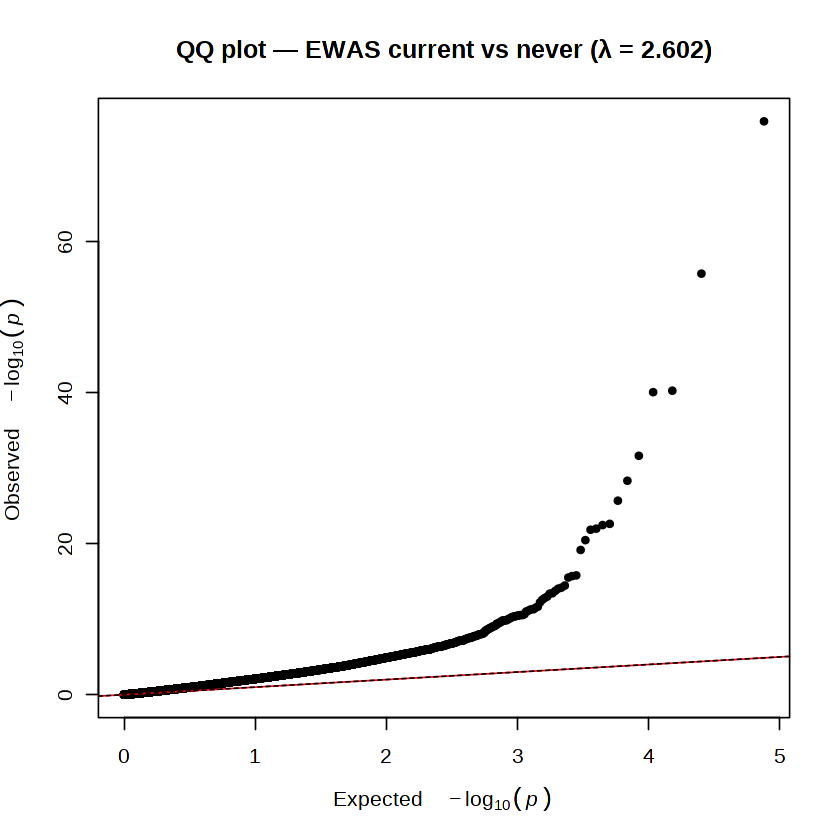

In [23]:
# Get p values
p <- results_table$p.value

# Compute lambda
p <- p[!is.na(p) & is.finite(p)]
p[p == 0] <- .Machine$double.xmin           # avoid Inf in qchisq
chisq <- qchisq(1 - p, df = 1)              # observed chi^2
lambda <- median(chisq) / qchisq(0.5, 1)    # genomic inflation

# Plot QQ
qq(p, main = sprintf("QQ plot — EWAS current vs never (λ = %.3f)", lambda))
abline(0, 1, lty = 2)


In [24]:
# save plot
png(filename = file.path(getwd(), "qqplot.png"),
    width = 1800, height = 1800, res = 300)  # ~6"x6" at 300 dpi
qq(p, main = sprintf("QQ plot — EWAS current vs never (λ = %.3f)", lambda))
abline(0, 1, lty = 2)
dev.off()

agg_record_1060954113 
                    2

**Comment:**

Our λ ≈ 2.6 is high—much higher than the ~1.0 you’d hope for in a well-calibrated genome-wide test. In a real study this could signal unmodelled confounding or technical effects (e.g., cell composition, batch/array, age/sex, population structure/relatedness, or outliers/collinearity).

In this practicum, the dataset is a small, curated subset enriched for smoking hits, so the p-value distribution is dominated by true associations. That naturally bends the QQ plot upward and inflates λ; here it’s not evidence of a problem.

Good practice: compare unadjusted, covariate-adjusted, and adjusted+SVA models (with a sensible cap on SVs). λ should usually decrease with appropriate adjustment. Use FDR to call discoveries; if you want a calibration check when many true effects are present, consider methods like bacon rather than relying solely on raw λ.

### **4.4.2 Significant CpGs**

We focus on CpGs that pass a multiple-testing threshold—here we’ll use **FDR < 0.05**. These are the sites most likely to show a real association between Smoking (current vs never) and methylation.

How to read the effect:
- **Positive effect**: higher methylation in current smokers vs never (hypermethylation).
- **Negative effect**: lower methylation in current smokers vs never (hypomethylation).



In [25]:
fdr_sig_results <- results_table[!is.na(results_table$fdr) & results_table$fdr < 0.05, , drop = FALSE]
head(fdr_sig_results)

,p.value,fdr,p.holm,t.statistic,coefficient,coefficient.ci.high,coefficient.ci.low,coefficient.se,n,chromosome,position
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<int>
cg03274069,6.321988e-05,0.003950910,1,4.095863,0.034592487,0.051256589,0.017928384,0.008445714,188,chrX,153906245
cg05100261,2.269469e-03,0.038698613,1,3.096326,0.008914041,0.014594370,0.003233712,0.002878909,188,chrX,154398413
cg07764473,6.531688e-04,0.018445681,1,3.468532,0.025497141,0.040001260,0.010993023,0.007350989,188,chrX,40178257
cg09626131,3.095986e-03,0.046662556,1,-2.998154,-0.014622173,-0.004999326,-0.024245021,0.004877059,188,chrX,83509529
cg12901451,7.107423e-05,0.004289619,1,4.068289,0.020200484,0.029999013,0.010401954,0.004965352,184,chrX,48761757
cg14393649,1.645993e-03,0.032146996,1,3.195444,0.013502175,0.021839334,0.005165016,0.004225446,188,chrX,49178100


In [26]:
cat("Number of FDR-significant CpGs (FDR < 0.05):", nrow(fdr_sig_results), "\n")
cat("Positive effects (current > never):", sum(fdr_sig_results$coefficient > 0, na.rm = TRUE), "\n")
cat("Negative effects (current < never):", sum(fdr_sig_results$coefficient < 0, na.rm = TRUE), "\n")

Number of FDR-significant CpGs (FDR < 0.05): 2668 
Positive effects (current > never): 931 
Negative effects (current < never): 1737 


**Comment:**
We identified 2,668 significant CpGs (FDR < 0.05) out of 37,842 tested (≈ 7.1%). Among these, 931 (34.9%) show a positive effect—higher methylation in current smokers vs never—while 1,737 (65.1%) show a negative effect, indicating lower methylation in current smokers.

### **4.4.3 Volcano Plots**
A volcano plot lets us to a look at the EWAS results quickly:
- x-axis: effect size (regression coefficient; current − never on the modeling scale, e.g., M-values).
  - Right side (positive) → higher methylation in current smokers.
  - Left side (negative) → lower methylation in current smokers.

* y-axis: statistical strength (−log10(p-value)); higher = more significant.

We add a horizontal line at our significance threshold (e.g., the p-value that corresponds to FDR < 0.05) and, optionally, vertical lines to mark a practical effect-size cutoff. Points in the upper right are significant hypermethylated CpGs; points in the upper left are significant hypomethylated CpGs.

We’ll also color the points by significance (e.g., red/blue for FDR < 0.05, grey otherwise) so significant CpGs stand out.

Warning message:
"Removed 4 rows containing missing values or values outside the scale range
(`geom_point()`)."


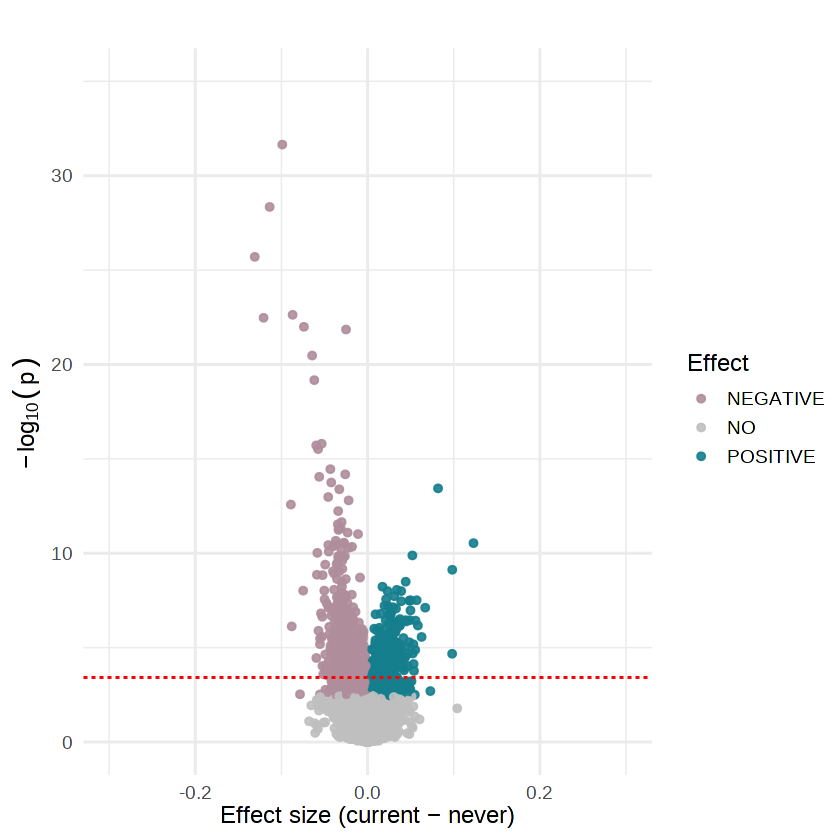

In [27]:
# Use full results table (all CpGs), not only the FDR<0.05 subset
res <- results_table

# Flag direction + significance
res$diffexpressed <- "NO"
res$diffexpressed[!is.na(res$fdr) & res$fdr < 0.05 & res$coefficient > 0] <- "POSITIVE"
res$diffexpressed[!is.na(res$fdr) & res$fdr < 0.05 & res$coefficient < 0] <- "NEGATIVE"

# Colors
mycolors <- c("POSITIVE" = "#157F8D", "NEGATIVE" = "#AF8D9B", "NO" = "grey")

# (Optional) draw a horizontal line at a p-value that corresponds to your chosen FDR cutoff.
# If you have a p-value threshold (e.g., 3.86e-04), keep it; otherwise omit the hline.
p_thresh <- 3.86e-04

p <- ggplot(res, aes(x = coefficient, y = -log10(p.value), color = diffexpressed)) +
  geom_point(size = 1.5, alpha = 0.9) +
  scale_colour_manual(values = mycolors, name = "Effect") +
  labs(title = "", x = "Effect size (current − never)", y = expression(-log[10](p))) +
  theme_minimal(base_size = 14) +
  theme(axis.title = element_text(color = "black"),
        plot.title = element_text(face = "bold", hjust = 0.5),
        legend.title = element_text(color = "black")) +
  xlim(c(-0.3, 0.3)) + ylim(c(0, 35)) +
  geom_hline(yintercept = -log10(p_thresh), linetype = "dashed", color = "red")

p

In [ ]:
# save plot
save_to <- file.path(getwd(), "volcano.png")
ggplot2::ggsave(filename = save_to,plot = p,width = 6, height = 5, units = "in", dpi = 300, device = "png")

Warning message:
"Removed 4 rows containing missing values or values outside the scale range
(`geom_point()`)."


### **4.4.4 Manhattan Plot**

A Manhattan plot displays p-values across the genome:
- x-axis: chromosomal position (hg19).
- y-axis: significance (−log10(p)).
- Dashed lines often mark epigenome-wide (p = 1×10⁻⁷ → y = 7) and suggestive (p = 1×10⁻⁵ → y = 5) thresholds.
- Points rising high on a chromosome indicate CpGs with strong associations.

Addionally, we can color significant hits (e.g., FDR < 0.05) so they stand out against the background.

In [28]:
# PREPARE DATA FOR PLOTTING
res <- results_table  # must have: chromosome, position, p.value

# Build data.frame in qqman format
df <- data.frame(SNP = rownames(res),
                 CHR = gsub("^chr", "", as.character(res$chromosome), ignore.case = TRUE),
                 BP = as.integer(res$position),
                 P = res$p.value,
                 stringsAsFactors = FALSE)

# Tidy chromosomes -> numeric (X=23, Y=24), drop weird ones
df$CHR[df$CHR %in% c("X","x")] <- 23
df$CHR[df$CHR %in% c("Y","y")] <- 24
df$CHR <- suppressWarnings(as.integer(df$CHR))
df <- df[!is.na(df$CHR) & !is.na(df$BP) & !is.na(df$P), ]

# Highlight FDR<0.05 hits (optional)
hl <- rownames(res)[!is.na(res$fdr) & res$fdr < 0.05]

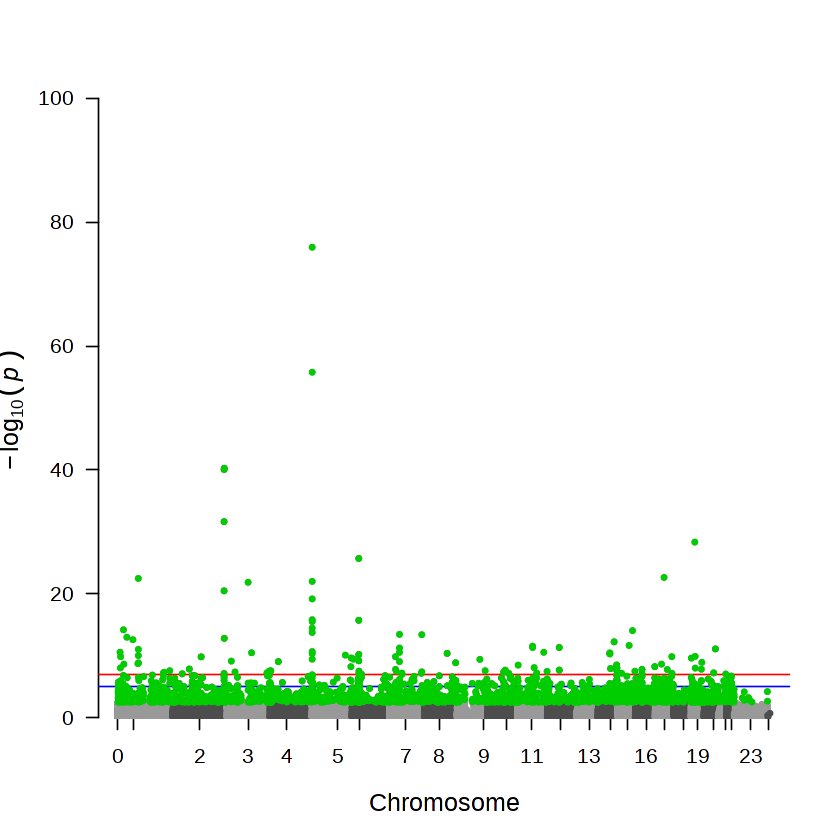

In [29]:

# PLOT
#png_path <- file.path(getwd(), "manhattan.png")

# Open PNG device (≈14x5 in at 300 dpi)
#png(filename = png_path, width = 14, height = 5, units = "in", res = 300)

#options(repr.plot.width = 14, repr.plot.height = 5)

manhattan(df, ylim = c(0, 100),
          cex = 0.7,     # point size
          cex.axis = 1.0, cex.lab = 1.2, # axis/text sizes
          col = c("grey30","grey60"), # alternating chrom colors
          genomewideline = -log10(1e-7),
          suggestiveline = -log10(1e-5),
          highlight = hl)   # FDR<0.05 hits
#dev.off()

**Comment:**
The Manhattan plot shows the strongest signals clustered on chromosome 5 (a classic smoking region around AHRR), with additional peaks on chromosomes 2 and 20.

### **Additional: Report meffil**

Addtiionally meffil allows to create a report by  meffil.ewas.parameters() and meffil.ewas.summary() functions. This report contains:
- Sample characteristics
- Covariate associations: Associations between the exposure variable (Smoking) and the covariates.
- Lambdas and QQplots to examine inflation (none, all cov, sva)
- Manhattan plots
- Significant CpG sites. As threshold we will indicate FDR=0.05.
- Specific CpGs Box plot: To observe the methylation differences between Never VS Current smokers, you can specify the CpGs that you are interested in.

Today we will select our top significant CpG “cg05575921” that is annotated to AHRR gene and it is well known for its association with tabbacco.

In [ ]:
res <- results_table
p_cut <- if (any(!is.na(res$fdr) & res$fdr < 0.05)) max(res$p.value[res$fdr < 0.05], na.rm=TRUE) else 1e-5
p_cut

[1] 0.00352098

In [ ]:
ewas_parameters <- meffil.ewas.parameters(max.plots = 1,
                                          model="all",  # model label: "none" (unadj) or "all" (adj) (opt: "sva")
                                          sig.threshold = p_cut) #FDR (0.05) = p.value (0.035)
# Choose a cpg to include in the report
candidate_cpg <- c("cg05575921")

# Built summary object for the report
ewas_summary <- meffil.ewas.summary(rlm_results_ewas_smokers, #meffil.ewas() results
                                    methyl_smokers,     # methyaltion matrix
                                    selected.cpg.sites = candidate_cpg,
                                    parameters = ewas_parameters)

# write the HTML report
meffil.ewas.report(ewas_summary, output.file = file.path(getwd(),"EWAS_report_smoking.html"))

[meffil.ewas.summary] Wed Oct 22 15:09:13 2025 QQ plots 
[meffil.ewas.summary] Wed Oct 22 15:09:15 2025 Manhattan plots 


Warning message:
"The `<scale>` argument of `guides()` cannot be `FALSE`. Use "none" instead as
of ggplot2 3.3.4.
ℹ The deprecated feature was likely used in the meffil package.
  Please report the issue to the authors."


[meffil.ewas.summary] Wed Oct 22 15:09:15 2025 CpG site plots: 1 
[FUN] Wed Oct 22 15:09:15 2025 Plotting cg05575921 
[meffil.ewas.summary] Wed Oct 22 15:09:15 2025 Sample characteristics 
[meffil.ewas.sample.characteristics] Wed Oct 22 15:09:15 2025 summarizing variables 
[summarize.variable] Wed Oct 22 15:09:15 2025 variable of interest 
[summarize.variable] Wed Oct 22 15:09:15 2025 Age 
[summarize.variable] Wed Oct 22 15:09:15 2025 Sex 
[summarize.variable] Wed Oct 22 15:09:15 2025 Bcell 
[summarize.variable] Wed Oct 22 15:09:15 2025 CD4T 
[summarize.variable] Wed Oct 22 15:09:15 2025 CD8T 
[summarize.variable] Wed Oct 22 15:09:15 2025 Mono 
[meffil.ewas.covariate.associations] Wed Oct 22 15:09:15 2025 covariate associations 
[FUN] Wed Oct 22 15:09:15 2025 Age 


Warning message in cor.test.default(vars[[var1]], as.integer(vars[[var2]]), method = "s"):
"Cannot compute exact p-value with ties"


[FUN] Wed Oct 22 15:09:15 2025 Sex 


Warning message in cor.test.default(as.integer(vars[[1]]), as.integer(vars[[2]]), :
"Cannot compute exact p-value with ties"


[FUN] Wed Oct 22 15:09:15 2025 Bcell 


Warning message in cor.test.default(vars[[var1]], as.integer(vars[[var2]]), method = "s"):
"Cannot compute exact p-value with ties"


[FUN] Wed Oct 22 15:09:15 2025 CD4T 


Warning message in cor.test.default(vars[[var1]], as.integer(vars[[var2]]), method = "s"):
"Cannot compute exact p-value with ties"


[FUN] Wed Oct 22 15:09:15 2025 CD8T 


Warning message in cor.test.default(vars[[var1]], as.integer(vars[[var2]]), method = "s"):
"Cannot compute exact p-value with ties"


[FUN] Wed Oct 22 15:09:15 2025 Mono 


Warning message in cor.test.default(vars[[var1]], as.integer(vars[[var2]]), method = "s"):
"Cannot compute exact p-value with ties"


[meffil.ewas.report] Wed Oct 22 15:09:15 2025 Writing report as html file to /content/EWAS_report_smoking.html 




processing file: /usr/local/lib/R/site-library/meffil/reports/ewas-report.rmd



1/36                   
2/36 [unnamed-chunk-1] 
3/36                   
4/36 [unnamed-chunk-2] 
5/36                   
6/36 [unnamed-chunk-3] 


Warning message in in_dir(input_dir(), expr):
"You changed the working directory to /content (probably via setwd()). It will be restored to /usr/local/lib/R/site-library/meffil/reports. See the Note section in ?knitr::knit"


7/36                   
8/36 [unnamed-chunk-4] 
9/36                   
10/36 [unnamed-chunk-5] 


Warning message in in_dir(input_dir(), expr):
"You changed the working directory to /content (probably via setwd()). It will be restored to /usr/local/lib/R/site-library/meffil/reports. See the Note section in ?knitr::knit"


11/36                   
12/36 [unnamed-chunk-6] 
13/36                   
14/36 [unnamed-chunk-7] 


Warning message in in_dir(input_dir(), expr):
"You changed the working directory to /content (probably via setwd()). It will be restored to /usr/local/lib/R/site-library/meffil/reports. See the Note section in ?knitr::knit"


15/36                   
16/36 [unnamed-chunk-8] 
17/36                   
18/36 [unnamed-chunk-9] 
19/36                   
20/36 [unnamed-chunk-10]
21/36                   
22/36 [unnamed-chunk-11]
23/36                   
24/36 [unnamed-chunk-12]
25/36                   
26/36 [unnamed-chunk-13]


Warning message in in_dir(input_dir(), expr):
"You changed the working directory to /content (probably via setwd()). It will be restored to /usr/local/lib/R/site-library/meffil/reports. See the Note section in ?knitr::knit"


27/36                   
28/36 [unnamed-chunk-14]
29/36                   
30/36 [unnamed-chunk-15]
31/36                   
32/36 [unnamed-chunk-16]


Warning message in in_dir(input_dir(), expr):
"You changed the working directory to /content (probably via setwd()). It will be restored to /usr/local/lib/R/site-library/meffil/reports. See the Note section in ?knitr::knit"


33/36                   
34/36 [unnamed-chunk-17]
35/36                   
36/36 [unnamed-chunk-18]


output file: /content/EWAS_report_smoking.md




[1] "/content/EWAS_report_smoking.html"

# **5. Downstream analysis** <a name="da"></a>

Downstream analyses help interpret the findings and identify cell-type or tissue-specific signals in epigenomic data.

- **Web pages resources:** EWAS Catalog / EWAS Atlas: paste your top CpG IDs to see prior associations, directions, tissues, and traits.

- **Illumina Annotation:** The Illumina annotation links each CpG to genomic features (e.g., nearby genes, promoter/gene body/UTR, CpG island/shore status, etc.). This helps describe where your significant CpGs sit.

- **Gene/pathway enrichment**: Using the gene(s) annotated to your CpGs, you can perform standard enrichment analyses (e.g., GO terms, Reactome).Each library (e.g., GO, Reactome) contains sets of biologically related genes (e.g., “inflammation”). Enrichment asks whether more of your CpG-annotated genes fall into a given term than expected by chance.

## **4.1 Annotation**

We first load the Illumina 450K annotation and attach a few useful columns (there are many more you can explore). For today we'll load directly a dataframe with the columns we're interested, but usually we follow this steps.


In [ ]:
data("IlluminaHumanMethylation450kanno.ilmn12.hg19")
annotation_table <- getAnnotation(IlluminaHumanMethylation450kanno.ilmn12.hg19)
dim(annotation_table)

[1] 485512     33

In [ ]:
# save annotatio
save_to <- file.path(getwd(),'450k_annotation.rds')
saveRDS(annotation_table, save_to)

In [ ]:
# Keep columns we're interested in
annotation_df <- as.data.frame(annotation_table[,c("chr","pos","strand",
                                                    "Name","Islands_Name",
                                                    "Relation_to_Island",
                                                    "UCSC_RefGene_Name",
                                                    "UCSC_RefGene_Group")])
head(annotation_df)

,chr,pos,strand,Name,Islands_Name,Relation_to_Island,UCSC_RefGene_Name,UCSC_RefGene_Group
,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
cg00050873,chrY,9363356,-,cg00050873,chrY:9363680-9363943,N_Shore,TSPY4;FAM197Y2,Body;TSS1500
cg00212031,chrY,21239348,-,cg00212031,chrY:21238448-21240005,Island,TTTY14,TSS200
cg00213748,chrY,8148233,-,cg00213748,chrY:8147877-8148210,S_Shore,,
cg00214611,chrY,15815688,-,cg00214611,chrY:15815488-15815779,Island,TMSB4Y;TMSB4Y,1stExon;5'UTR
cg00455876,chrY,9385539,-,cg00455876,chrY:9385471-9385777,Island,,
cg01707559,chrY,6778695,+,cg01707559,chrY:6778574-6780028,Island,TBL1Y;TBL1Y;TBL1Y,TSS200;TSS200;TSS200


In [ ]:
# save table
save_to <- file.path(getwd(),'450k_annotation_table.rds')
saveRDS(annotation_df, save_to)

In [30]:
# For this practical we have already run the ewas (meffil package takes a while to get installed)
annot_url <- "https://raw.githubusercontent.com/joanall/Hands-On-Epigenome-Wide-Analysis-EWAS-/main/data/450k_annotation_table.rds"

tmp <- tempfile(fileext = ".rds")
download.file(annot_url, destfile = tmp, mode = "wb")  # binary mode
annotation_df <- readRDS(tmp)
head(annotation_df)

,chr,pos,strand,Name,Islands_Name,Relation_to_Island,UCSC_RefGene_Name,UCSC_RefGene_Group
,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
cg00050873,chrY,9363356,-,cg00050873,chrY:9363680-9363943,N_Shore,TSPY4;FAM197Y2,Body;TSS1500
cg00212031,chrY,21239348,-,cg00212031,chrY:21238448-21240005,Island,TTTY14,TSS200
cg00213748,chrY,8148233,-,cg00213748,chrY:8147877-8148210,S_Shore,,
cg00214611,chrY,15815688,-,cg00214611,chrY:15815488-15815779,Island,TMSB4Y;TMSB4Y,1stExon;5'UTR
cg00455876,chrY,9385539,-,cg00455876,chrY:9385471-9385777,Island,,
cg01707559,chrY,6778695,+,cg01707559,chrY:6778574-6780028,Island,TBL1Y;TBL1Y;TBL1Y,TSS200;TSS200;TSS200


In [31]:
# CpG IDs in results tabble are rownames; in the annotation they’re in column "Name"
# Add probe ID as a column, merge, and keep all results
results_table$Probe <- rownames(results_table)

# Merge/Add new annotaiton columns to our resullts
results_table_anno <- merge(results_table, annotation_df, by.x = "Probe", by.y = "Name", all.x = TRUE, sort = FALSE)

# put Probe back as rownames
rownames(results_table_anno) <- results_table_anno$Probe

# Order by p-value (ascending)
results_table_anno <- results_table_anno[order(results_table_anno$p.value), ]

results_table_anno[1:10,]


,Probe,p.value,fdr,p.holm,t.statistic,coefficient,coefficient.ci.high,coefficient.ci.low,coefficient.se,n,chromosome,position,chr,pos,strand,Islands_Name,Relation_to_Island,UCSC_RefGene_Name,UCSC_RefGene_Group
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>
cg05575921,cg05575921,1.092977e-76,4.136045e-72,4.136045e-72,-32.01506,-0.24375516,-0.22873256,-0.25877776,0.007613766,188,chr5,373263,chr5,373378,+,chr5:373842-374426,N_Shore,AHRR,Body
cg23576855,cg23576855,1.661856e-56,3.144398e-52,6.288630e-52,-23.29780,-0.23729734,-0.21720069,-0.25739399,0.010185399,188,chr5,373299,chr5,373299,-,chr5:373842-374426,N_Shore,AHRR,Body
cg05951221,cg05951221,5.365715e-41,6.768313e-37,2.030387e-36,-17.54984,-0.11681691,-0.10368348,-0.12995034,0.006656296,188,chr2,233284402,chr2,233284402,+,chr2:233283397-233285959,Island,,
cg21566642,cg21566642,8.394078e-41,7.941217e-37,3.176235e-36,-17.48144,-0.16984745,-0.15067722,-0.18901768,0.009715872,188,chr2,232419951,chr2,233284661,-,chr2:233283397-233285959,Island,,
cg01940273,cg01940273,2.260473e-32,1.710816e-28,8.553176e-28,-14.56908,-0.09901592,-0.08560624,-0.11242560,0.006796305,188,chr2,232420224,chr2,233284934,-,chr2:233283397-233285959,Island,,
cg03636183,cg03636183,4.530138e-29,2.857158e-25,1.714068e-24,-13.44648,-0.11366698,-0.09698793,-0.13034604,0.008453292,188,chr19,16889774,chr19,17000585,-,chr19:17000627-17001398,N_Shore,F2RL3,Body
cg06126421,cg06126421,1.994295e-26,1.078116e-22,7.545614e-22,-12.54843,-0.13094919,-0.11035906,-0.15153932,0.010435504,188,chr6,30752303,chr6,30720080,-,,OpenSea,,
cg19572487,cg19572487,2.340553e-23,1.107140e-19,8.855484e-19,-11.50040,-0.08704351,-0.07210976,-0.10197726,0.007568736,188,chr17,40319772,chr17,38476024,-,chr17:38474197-38474980,S_Shore,RARA;RARA;RARA,5'UTR;5'UTR;5'UTR
cg09935388,cg09935388,3.376891e-23,1.419870e-19,1.277613e-18,-11.44575,-0.12073480,-0.09992184,-0.14154775,0.010548440,188,chr1,92482031,chr1,92947588,+,chr1:92945907-92952609,Island,GFI1;GFI1;GFI1,Body;Body;Body


In [32]:
# save merged
save_to <- file.path(getwd(),'ewas_results_annot.rds')
saveRDS(results_table_anno, save_to)


We can manually inspect the top hits to see where the genomic context (promoter/body/UTR, island/shore) and which genes they annotate to. In our top 10, we observe:
- cg05575921 and cg23576855 → annotated to AHRR (a well-known smoking locus).
- cg03636183 → annotated to F2RL3
- cg09935388 → annotated to GFI1.
- Several others (e.g., cg05951221, cg21566642, cg01940273, cg06126421, cg19572487) are located in CpG islands without a nearby annotated gene.

This quick check helps put the results into biological context before moving on to enrichment or region-based analyses. Also, when the number of significant CpGs is small, gene set enrichment can be hard (few or no annotated genes), so it’s always helpful to manually inspect the top hits

## **4.2. Enrichment**
To gain more biological insight we can perform enrichment analyses. This step is especially useful when we have many FDR-significant CpG–gene hits.

The idea is to compare the genes that overlap our FDR-significant CpGs with background gene sets from public databases (such as GO or Reactome) to check whether our genes are over-represented in any biological pathways or functions—meaning they appear more often than expected by chance.

From the annotated results, we’ll keep only the CpGs with FDR < 0.05 and extract their corresponding gene symbols.
Next, we’ll convert those gene symbols into standard identifiers—Ensembl and Entrez IDs.

In [34]:
# Time around 10'
enrich_pkgs <- c('ReactomePA',"clusterProfiler","org.Hs.eg.db") #"IlluminaHumanMethylation450kanno.ilmn12.hg19" annot
BiocManager::install(enrich_pkgs, ask = FALSE, update = FALSE)

library(ReactomePA)
library(clusterProfiler)
library(org.Hs.eg.db)

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    BioCsoft: https://bioconductor.org/packages/3.21/bioc
    BioCann: https://bioconductor.org/packages/3.21/data/annotation
    BioCexp: https://bioconductor.org/packages/3.21/data/experiment
    BioCworkflows: https://bioconductor.org/packages/3.21/workflows
    BioCbooks: https://bioconductor.org/packages/3.21/books
    CRAN: https://cran.rstudio.com

Bioconductor version 3.21 (BiocManager 1.30.26), R 4.5.1 (2025-06-13)

Warning message:
"package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'org.Hs.eg.db'"
Installing package(s) 'ReactomePA', 'clusterProfiler'

also installing the dependencies 'ggplotify', 'tidytree', 'treeio', 'fgsea', 'aplot', 'ggtangle', 'ggtree', 'tidygraph', 'graphlayouts', 'DOSE', 'enrichplot', 'ggraph', 'igraph'




ReactomePA v1.52.0 Learn more at 

In [35]:
# Get genes from CpGs with FDR < 0.05
fdr_genes <- results_table_anno$UCSC_RefGene_Name[results_table_anno$fdr < 0.05]

# Split multiple genes separated by ";" and keep unique entries
fdr_genes <- unique(unlist(strsplit(fdr_genes, ";")))
fdr_genes <- fdr_genes[fdr_genes != ""]
fdr_genes[1:10]

[1] "AHRR"    "F2RL3"   "RARA"    "GFI1"    "GPR15"   "ANPEP"   "MYO1G"  
 [8] "CNTNAP2" "SMAP2"   "GNG12"

### **4.2.1. GO terms**
We’ll start with Gene Ontology (GO) to test whether particular biological functions or pathways are over-represented in our gene list derived from FDR-significant CpGs.
For this, we’ll use the`clusterProfiler::enrichGO()`).

In [36]:
fdr_genes_ids <- bitr(fdr_genes,
                      fromType = "SYMBOL",
                      toType = c("ENSEMBL", "ENTREZID"),
                      OrgDb = org.Hs.eg.db)

head(fdr_genes_ids)

'select()' returned 1:many mapping between keys and columns

Warning message in bitr(fdr_genes, fromType = "SYMBOL", toType = c("ENSEMBL", "ENTREZID"), :
"14.09% of input gene IDs are fail to map..."


,SYMBOL,ENSEMBL,ENTREZID
,<chr>,<chr>,<chr>
1,AHRR,ENSG00000063438,57491
2,F2RL3,ENSG00000127533,9002
3,RARA,ENSG00000131759,5914
4,GFI1,ENSG00000162676,2672
5,GPR15,ENSG00000154165,2838
6,ANPEP,ENSG00000166825,290


In [37]:
# Define background universe (all human ENTREZ IDs in org.Hs.eg.db)
universe_entrez <- keys(org.Hs.eg.db, keytype = "ENTREZID")

# Perform enrichment
results_enrich_go <- enrichGO(gene = fdr_genes_ids$ENTREZID,
                              OrgDb = org.Hs.eg.db,
                              keyType = "ENTREZID",
                              ont = "BP",
                              universe = universe_entrez,  # if you defined it
                              pAdjustMethod = "BH",
                              pvalueCutoff = 0.05,
                              qvalueCutoff = 0.2,
                              minGSSize = 6,
                              readable= TRUE)

In [40]:
head(results_enrich_go@result)

,ID,Description,GeneRatio,BgRatio,RichFactor,FoldEnrichment,zScore,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0031589,GO:0031589,cell-substrate adhesion,58/1434,361/18805,0.1606648,2.106905,6.101319,4.732788e-08,0.0003103762,0.0002784872,MYO1G/PTK2/HOXA7/ITGAL/SORBS1/ITGB2/PTPRJ/CTTN/COL1A1/CD96/SMAD6/ITGA1/DOCK5/LPXN/CORO2B/MIR92A1/SMAD3/BCL6/EFNA5/ITGB5/CDK6/CDC42/DOCK1/LAMB1/TBCD/CLASP2/SPRY4/NEDD9/CD44/PRKCZ/MAP4K4/PTPRO/ANTXR1/CRK/PARVA/EFEMP2/TNN/TMEM8B/ITGA2B/SNED1/TRIOBP/LIMS1/PIK3R1/ARHGEF7/PKHD1/ZYX/CLASP1/CDK5/RAB1A/KIF14/PTK2B/JAM3/ITGAM/SGCE/TNXB/PHLDB2/THBS1/EPB41L5,58
GO:0071559,GO:0071559,response to transforming growth factor beta,52/1434,315/18805,0.1650794,2.164796,5.989961,9.586962e-08,0.0003143565,0.0002820585,PTK2/ZMIZ1/RUNX3/COL1A1/SMAD6/LPXN/MIR19A/MIR20A/MIR17/MIR19B1/MIR18A/CFLAR/SMAD3/HIPK2/PRDM16/ITGB5/IGF1R/PMEPA1/LTBP4/TET1/SKI/ARRB2/NLK/NFATC1/ZFHX3/COL4A2/LRRC32/CRK/BMPR1A/WFIKKN2/ACTA2/LIMS1/CDH3/ZYX/FBN2/STRAP/PPARA/ZBTB7A/SMURF2/FURIN/TP53/SPRED2/PEG10/GDF10/LATS2/THBS1/ING2/MTMR4/HDAC1/FKBP1A/LATS1/EPB41L5,52
GO:0002181,GO:0002181,cytoplasmic translation,34/1434,169/18805,0.2011834,2.638253,6.146603,1.473149e-07,0.0003220304,0.0002889440,RPL35/RPL23A/RPS18/RPL8/RPS12/RPL37/RPL4/EIF4G1/RPL7A/RPL13A/RPS6/RPL17/RPL28/RPL27A/UNK/RPS11/RPS25/EIF4A2/RPL18A/RPS2/RPL23/NMNAT2/RPS28/RPL12/METTL3/RPSA/RPL3/EIF4A1/NCK1/RPL10/RPS8/DHX29/ALKBH3/NCBP1,34
GO:0071560,GO:0071560,cellular response to transforming growth factor beta stimulus,50/1434,308/18805,0.1623377,2.128842,5.739119,2.856948e-07,0.0004683966,0.0004202721,PTK2/ZMIZ1/COL1A1/SMAD6/LPXN/MIR19A/MIR20A/MIR17/MIR19B1/MIR18A/CFLAR/SMAD3/HIPK2/PRDM16/ITGB5/IGF1R/PMEPA1/LTBP4/TET1/SKI/ARRB2/NLK/NFATC1/COL4A2/LRRC32/CRK/BMPR1A/WFIKKN2/ACTA2/LIMS1/CDH3/ZYX/FBN2/STRAP/PPARA/ZBTB7A/SMURF2/FURIN/TP53/SPRED2/PEG10/GDF10/LATS2/THBS1/ING2/MTMR4/HDAC1/FKBP1A/LATS1/EPB41L5,50
GO:0007264,GO:0007264,small GTPase-mediated signal transduction,69/1434,487/18805,0.1416838,1.857994,5.511845,4.008609e-07,0.0005257691,0.0004717499,ARRB1/CDKN1A/CDC42SE1/GNB1/PLEKHG1/CCDC88C/ARHGEF2/GIT1/ARHGAP12/RAPGEF1/DOCK5/TIAM2/DENND4A/MCF2L/SH2B2/BCL6/RHOG/NGF/CDC42/CCDC88A/DOCK1/ARHGEF19/RALA/GPR55/ARHGEF3/ITPKB/TSC2/PLEKHG4/FGF2/SPRY4/ABR/SH2D3A/DOCK9/ARHGEF10/DOCK2/RAPGEF5/MAP4K4/GNA12/RAPGEF2/PSD3/FLOT1/CRK/DHCR24/TRIO/ARHGEF18/KRIT1/FARP1/BCAR3/ARHGEF7/SIAH2/SYNGAP1/CHN1/DAB1/ARHGEF11/RALGPS2/RIT1/RGL2/KIF14/SQSTM1/ARHGAP26/TP53/RALGDS/KALRN/PSD2/CYTH4/CYTH1/RUFY1/DENND3/GMIP,69
GO:0007160,GO:0007160,cell-matrix adhesion,40/1434,240/18805,0.1666667,2.185611,5.311140,2.205030e-06,0.0024100981,0.0021624771,PTK2/HOXA7/ITGAL/SORBS1/ITGB2/PTPRJ/CTTN/CD96/ITGA1/CORO2B/MIR92A1/SMAD3/BCL6/EFNA5/ITGB5/CDK6/CLASP2/CD44/PRKCZ/MAP4K4/EFEMP2/TNN/TMEM8B/ITGA2B/SNED1/LIMS1/PIK3R1/ARHGEF7/PKHD1/ZYX/CLASP1/CDK5/PTK2B/JAM3/ITGAM/SGCE/TNXB/PHLDB2/THBS1/EPB41L5,40


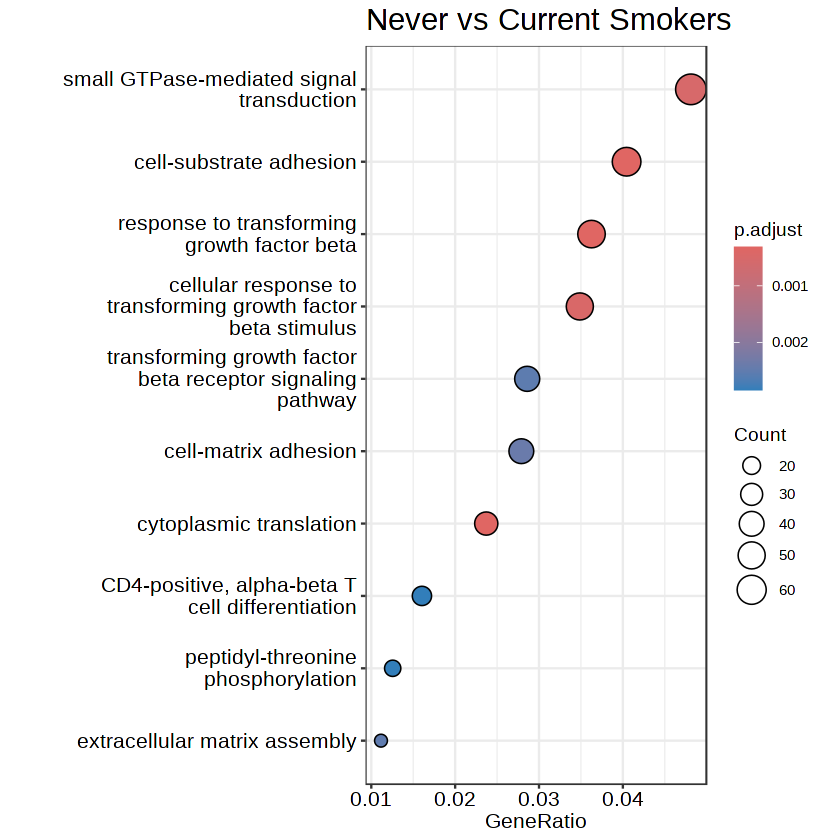

In [41]:
# Plot
p <- enrichplot::dotplot(
  results_enrich_go,
  showCategory = 10,
  x = "GeneRatio"     # or "Count"
) +
  ggtitle("Never vs Current Smokers") +
  theme(plot.title = element_text(size = 18))

print(p)

In [42]:
# save plot
save_to <- file.path(getwd(), "dotplot_go_ernichment.png")
ggplot2::ggsave(filename = save_to, plot = p,width = 6, height = 5, units = "in", dpi = 300, device = "png")

**Comment:**
Smoking-associated CpG changes are enriched for pathways in TGF-β signaling, small GTPase signaling, and cell/ECM adhesion—suggesting impacts on tissue remodeling and immune-related signaling.


### **4.2.2. PariWaise Similary**
Another enrichment analysis we can perform is to examine the semantic similarity of GO terms. This is done using the `GOSemSim` R package, which calculates semantic similarity between Gene Ontology (GO) terms, gene products, or gene clusters. This approach helps identify functionally related terms, cluster similar biological processes, and reduce redundancy in GO enrichment results.

In [43]:
# Semantic similarity data (newer GOSemSim prefers `annoDb=`)
semData <- GOSemSim::godata(annoDb = "org.Hs.eg.db",
                            ont = "BP", computeIC = FALSE)

# Pairwise term similarity (Wang semantic similarity for GO)
res_pair <- enrichplot::pairwise_termsim(results_enrich_go,
                                        method = "Wang",
                                        semData = semData)

preparing gene to GO mapping data...



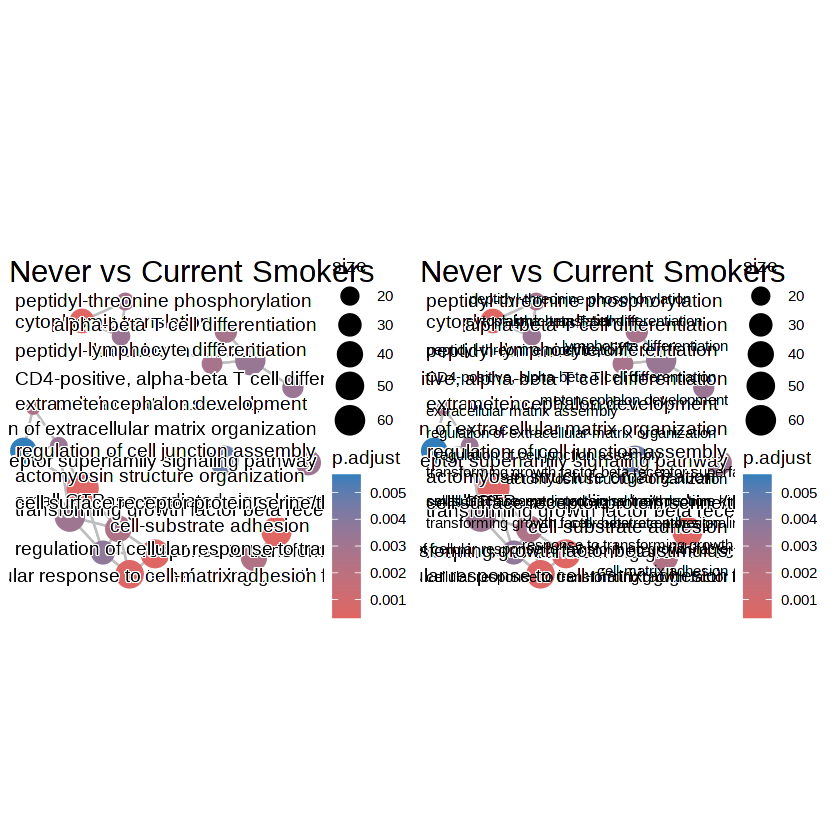

In [54]:
# Plot
set.seed(123)
p_map <- enrichplot::emapplot(res_pair, showCategory = 21, layout = "fr",
                              min_edge = 0.25, color = "p.adjust") +

  ggtitle("Never vs Current Smokers") +
  theme(plot.title = element_text(size = 18)) +
suppressWarnings(print(p_map))

In [47]:
# save plot
save_to <- file.path(getwd(), "sim_go_ernichment.png")
ggplot2::ggsave(filename = save_to, plot = p_map,width = 10, height=6, units = "in", dpi = 300, device = "png")

**Comment**:
- Nodes = enriched GO terms (colored by adjusted p-value)
- Edges = semantic similarity (thicker = more related)

Functionally related GO terms cluster together, revealing connected biological processes such as TGF-β signaling, extracellular matrix organization, and cell adhesion that are enriched among smoking-associated CpGs.

### **4.2.3 Reactome**

Reactome is a database with curated pathways that describe how molecules cooperate in processes like signaling, cell–matrix interaction, and immune responses. Rather than looking at the genes one-by-one, we test groups of functionally connected genes (via GSEA). The input is a ranked vector where each Entrez Gene ID is paired with its log₂ fold change (current vs. never smokers).

In [55]:
# Define universe
universe_entrez <- keys(org.Hs.eg.db, keytype = "ENTREZID")

# Perform enrichment
results_enrich_reactome <- enrichPathway(gene = fdr_genes_ids$ENTREZID,
                                         organism = "human",
                                         universe = universe_entrez,
                                         pAdjustMethod = "BH",
                                         pvalueCutoff = 0.05,
                                         qvalueCutoff = 0.2,
                                         minGSSize = 6,
                                         readable = TRUE)

# Table view
results_enrich_reactome_df <- as.data.frame(results_enrich_reactome)
head(results_enrich_reactome_df)

,ID,Description,GeneRatio,BgRatio,RichFactor,FoldEnrichment,zScore,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
R-HSA-156842,R-HSA-156842,Eukaryotic Translation Elongation,28/950,94/11214,0.2978723,3.516148,7.452673,1.840785e-09,2.972868e-06,2.734050e-06,EEF2/RPL35/RPL23A/RPS18/RPL8/RPS12/RPL37/RPL4/RPL7A/RPL13A/RPS6/RPL17/RPL28/RPL27A/RPL36AL/RPS11/RPS25/RPL18A/RPS2/RPL23/RPS28/RPL12/RPSA/RPL3/EEF1G/RPL10/RPS8/EEF1B2,28
R-HSA-975956,R-HSA-975956,Nonsense Mediated Decay (NMD) independent of the Exon Junction Complex (EJC),27/950,96/11214,0.2812500,3.319934,6.944842,1.419178e-08,7.657181e-06,7.042062e-06,RPL35/RPL23A/RPS18/RPL8/RPS12/RPL37/RPL4/EIF4G1/RPL7A/RPL13A/RPS6/RPL17/RPL28/RPL27A/RPL36AL/RPS11/RPS25/RPL18A/RPS2/RPL23/RPS28/RPL12/RPSA/RPL3/RPL10/RPS8/NCBP1,27
R-HSA-156902,R-HSA-156902,Peptide chain elongation,26/950,90/11214,0.2888889,3.410105,6.983790,1.422387e-08,7.657181e-06,7.042062e-06,EEF2/RPL35/RPL23A/RPS18/RPL8/RPS12/RPL37/RPL4/RPL7A/RPL13A/RPS6/RPL17/RPL28/RPL27A/RPL36AL/RPS11/RPS25/RPL18A/RPS2/RPL23/RPS28/RPL12/RPSA/RPL3/RPL10/RPS8,26
R-HSA-72764,R-HSA-72764,Eukaryotic Translation Termination,26/950,94/11214,0.2765957,3.264994,6.708772,3.828742e-08,1.494517e-05,1.374459e-05,RPL35/RPL23A/RPS18/RPL8/RPS12/RPL37/APEH/RPL4/RPL7A/RPL13A/RPS6/RPL17/RPL28/RPL27A/RPL36AL/RPS11/RPS25/RPL18A/RPS2/RPL23/RPS28/RPL12/RPSA/RPL3/RPL10/RPS8,26
R-HSA-9633012,R-HSA-9633012,Response of EIF2AK4 (GCN2) to amino acid deficiency,27/950,102/11214,0.2647059,3.124644,6.557745,5.782393e-08,1.494517e-05,1.374459e-05,RPL35/ATF4/RPL23A/RPS18/RPL8/RPS12/RPL37/RPL4/RPL7A/RPL13A/RPS6/RPL17/RPL28/RPL27A/RPL36AL/RPS11/RPS25/RPL18A/ATF2/RPS2/RPL23/RPS28/RPL12/RPSA/RPL3/RPL10/RPS8,27
R-HSA-192823,R-HSA-192823,Viral mRNA Translation,25/950,90/11214,0.2777778,3.278947,6.603732,6.367393e-08,1.494517e-05,1.374459e-05,RPL35/RPL23A/RPS18/RPL8/RPS12/RPL37/RPL4/RPL7A/RPL13A/RPS6/RPL17/RPL28/RPL27A/RPL36AL/RPS11/RPS25/RPL18A/RPS2/RPL23/RPS28/RPL12/RPSA/RPL3/RPL10/RPS8,25


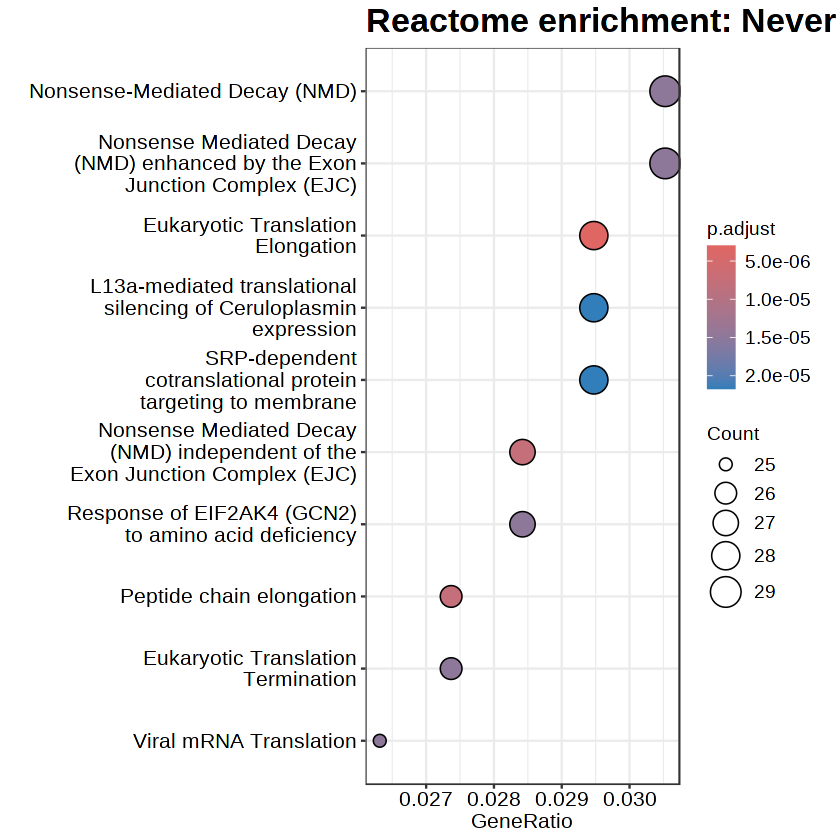

In [58]:
# Dot plot of top Reactome pathways
p_react_dot <- enrichplot::dotplot(results_enrich_reactome,
                                   showCategory = 10,
                                   x = "GeneRatio") +
  ggtitle("Reactome enrichment: Never vs Current Smokers") +
  theme(plot.title  = element_text(size = 20, face = "bold"),
        axis.text   = element_text(size = 12),
        legend.text = element_text(size = 11))
p_react_dot

In [60]:
# save plot
save_to <- file.path(getwd(), "dotplot_reactome_enrichment.png")
ggplot2::ggsave(filename = save_to, plot = p_react_dot, width = 12, height = 8, units = "in", dpi = 300, bg = "white")

**Comment**

For current smokers, enriched Reactome pathways are mainly related to translation and protein synthesis processes, such as nonsense-mediated decay (NMD), eukaryotic translation elongation, and peptide chain elongation. These functions are reltated altered gene expression and protein metabolism in response to smoking exposure.

# **Some recommendations:**

Design and analysis of epigenome wide association studies
Campagna, M.P., Xavier, A., Lechner-Scott, J. et al. **Epigenome-wide association studies: current knowledge, strategies and recommendations.** Clin Epigenet 13, 214 (2021). https://doi.org/10.1186/s13148-021-01200-8

Min JL, Hemani G, Davey Smith G, Relton C, Suderman M. **Meffil: efficient normalization and analysis of very large DNA methylation datasets.** Bioinformatics. 2018 Dec 1;34(23):3983-3989. doi: 10.1093/bioinformatics/bty476. PMID: 29931280; PMCID: PMC6247925.

Huber, W., Carey, V., Gentleman, R. et al. **Orchestrating high-throughput genomic analysis with Bioconductor.** Nat Methods 12, 115–121 (2015). https://doi.org/10.1038/nmeth.3252



